# Data Coverage
Exploring the NYC Building Elevation and Subgrade (BES) Dataset in Python

Author: Mark Bauer

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import duckdb
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rcParams['savefig.facecolor'] = 'white'
%matplotlib inline

In [2]:
# Printing verions of Python modules and packages with **watermark** - the IPython magic extension.
%reload_ext watermark
%watermark -v -p numpy,pandas,matplotlib,seaborn,duckdb

Python implementation: CPython
Python version       : 3.8.13
IPython version      : 8.4.0

numpy     : 1.23.1
pandas    : 1.4.3
matplotlib: 3.5.2
seaborn   : 0.11.2
duckdb    : 0.10.0



![cover-photo](images/dataset-cover-photo.png)
Screenshot of data set on NYC Open Data.

Link to dataset website: https://data.cityofnewyork.us/City-Government/Building-Elevation-and-Subgrade-BES-/bsin-59hv

In [3]:
# create a DuckDB database instance
con = duckdb.connect()

# examine count of rows
con.sql("SELECT COUNT(*) AS count_rows FROM read_parquet('data/bes-data.parquet')").show()

┌────────────┐
│ count_rows │
│   int64    │
├────────────┤
│     861876 │
└────────────┘



In [4]:
# explore data as a dataframe
df = con.sql("SELECT * FROM read_parquet('data/bes-data.parquet')").df()

rows, cols = df.shape
print('rows: {:,}\ncolumns: {}'.format(rows, cols))

# preview data
df.head()

rows: 861,876
columns: 26


,the_geom,bin,bbl,borough,block,lot,address,z_grade,z_floor,subgrade,...,longitude,pluto_bbl,Council,BoroCD,CTLabel,BoroCT2020,NTA2020,NTAName,CDTA2020,CDTAName
0,POINT (-74.22274561187417 40.52134422844183),5128004,5075340353,5.0,7534.0,353,78 SAVO LOOP,29.428,32.332,N,...,-74.222746,5075340353,51,503,226.01,5022601,SI0304,Annadale-Huguenot-Prince's Bay-Woodrow,SI03,SI03 South Shore (CD 3 Approximation)
1,POINT (-74.24179250549321 40.52875316810818),5155392,5075960125,5.0,7596.0,125,72 CHART LOOP,25.366,26.703,N,...,-74.241793,5075960125,51,503,226.02,5022602,SI0305,Tottenville-Charleston,SI03,SI03 South Shore (CD 3 Approximation)
2,POINT (-74.24109012652094 40.528883822921635),5148808,5075960131,5.0,7596.0,131,40 TIDES LANE,36.172,38.902,N,...,-74.241090,5075960131,51,503,226.02,5022602,SI0305,Tottenville-Charleston,SI03,SI03 South Shore (CD 3 Approximation)
3,POINT (-74.24649640323727 40.507045708438184),5088274,5079150042,5.0,7915.0,42,328 MAIN STREET,69.897,72.459,N,...,-74.246496,5079150042,51,503,244.01,5024401,SI0305,Tottenville-Charleston,SI03,SI03 South Shore (CD 3 Approximation)
4,POINT (-74.24198032271697 40.51005666426356),5087850,5078680123,5.0,7868.0,123,309 SLEIGHT AVENUE,74.907,79.122,N,...,-74.241980,5078680123,51,503,244.01,5024401,SI0305,Tottenville-Charleston,SI03,SI03 South Shore (CD 3 Approximation)


In [5]:
# is identification number unique
is_unique = df['bin'].is_unique

print('Building Identification Number (BIN) field is unique: {}'.format(is_unique))

Building Identification Number (BIN) field is unique: True


In [6]:
# preview datatypes and non-null counts
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 861876 entries, 0 to 861875
Data columns (total 26 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   the_geom    861876 non-null  object 
 1   bin         861876 non-null  int64  
 2   bbl         861876 non-null  int64  
 3   borough     861875 non-null  float64
 4   block       861875 non-null  float64
 5   lot         861876 non-null  int64  
 6   address     844875 non-null  object 
 7   z_grade     861876 non-null  float64
 8   z_floor     861876 non-null  float64
 9   subgrade    861876 non-null  object 
 10  notes1      861876 non-null  object 
 11  notes2      202458 non-null  object 
 12  notes3      472003 non-null  object 
 13  x           861876 non-null  float64
 14  y           861876 non-null  float64
 15  latitude    861876 non-null  float64
 16  longitude   861876 non-null  float64
 17  pluto_bbl   861876 non-null  int64  
 18  Council     861876 non-null  int64  
 19  Bo

In [7]:
# preview null counts per column
(df
 .isnull()
 .sum()
 .sort_values(ascending=False)
)

notes2        659418
notes3        389873
address        17001
borough            1
block              1
the_geom           0
longitude          0
CDTA2020           0
NTAName            0
NTA2020            0
BoroCT2020         0
CTLabel            0
BoroCD             0
Council            0
pluto_bbl          0
x                  0
latitude           0
y                  0
bin                0
notes1             0
subgrade           0
z_floor            0
z_grade            0
lot                0
bbl                0
CDTAName           0
dtype: int64

Note: there is one building with null borough and block value.

In [8]:
# summary statistics of selected numeric columns
cols = [
    'bin',
    'z_grade', 'z_floor', 
    'x', 'y', 'latitude', 'longitude'
]

df.loc[:, cols].describe()

,bin,z_grade,z_floor,x,y,latitude,longitude
count,8.618760e+05,861876.000000,861876.000000,8.618760e+05,861876.000000,861876.000000,861876.000000
mean,3.610723e+06,53.915012,58.113704,1.006345e+06,191685.085757,40.692719,-73.920238
std,1.053307e+06,42.192895,42.560673,3.288964e+04,30587.626141,0.083946,0.118567
min,1.000003e+06,-13.096000,0.000000,9.132653e+05,120977.993002,40.498478,-74.255266
25%,3.089156e+06,23.304000,27.438000,9.893564e+05,168135.316338,40.628135,-73.981596
50%,4.026428e+06,44.328000,48.370000,1.009009e+06,189533.841782,40.686807,-73.910686
75%,4.259005e+06,72.709250,77.063000,1.030179e+06,211378.936954,40.746741,-73.834218
max,5.799523e+06,402.839000,404.397000,1.067283e+06,272622.861956,40.914923,-73.700369


In [9]:
# summary statistics string columns
df.describe(include=['O'])

,the_geom,address,subgrade,notes1,notes2,notes3,NTA2020,NTAName,CDTA2020,CDTAName
count,861876,844875,861876,861876,202458,472003,861876,861876,861876,861876
unique,861876,796756,2,12,9,2,256,256,71,72
top,POINT (-74.22274561187417 40.52134422844183),FINGERBOARD ROAD,Y,Property was Successfully Measured,"Commercial, Industrial or other Non-Residentia...",Visible Door or Window in subgrade space,SI0302,Great Kills-Eltingville,SI03,SI03 South Shore (CD 3 Approximation)
freq,1,423,472003,646782,112354,310268,16194,16194,48095,48095


It's useful to have a full Neighborhood Tabulation Areas (NTA) and Borough column.

In [10]:
# reading in NTA shape, only being used as a df and not gdf
url = 'https://data.cityofnewyork.us/api/geospatial/9nt8-h7nd?accessType=DOWNLOAD&method=export&format=Shapefile'
nta_df = gpd.read_file(url)

print('shape of data: {}'.format(nta_df.shape))
nta_df.head()

shape of data: (262, 12)


,borocode,boroname,countyfips,nta2020,ntaname,ntaabbrev,ntatype,cdta2020,cdtaname,shape_leng,shape_area,geometry
0,3.0,Brooklyn,047,BK0101,Greenpoint,Grnpt,0,BK01,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),28912.566468,3.532121e+07,"POLYGON ((-73.93213 40.72816, -73.93238 40.727..."
1,3.0,Brooklyn,047,BK0102,Williamsburg,Wllmsbrg,0,BK01,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),28098.026671,2.885431e+07,"POLYGON ((-73.95814 40.72440, -73.95772 40.724..."
2,3.0,Brooklyn,047,BK0103,South Williamsburg,SWllmsbrg,0,BK01,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),18250.279986,1.520896e+07,"POLYGON ((-73.95024 40.70547, -73.94984 40.705..."
3,3.0,Brooklyn,047,BK0104,East Williamsburg,EWllmsbrg,0,BK01,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),43184.772485,5.226621e+07,"POLYGON ((-73.92406 40.71411, -73.92404 40.714..."
4,3.0,Brooklyn,047,BK0201,Brooklyn Heights,BkHts,0,BK02,BK02 Downtown Brooklyn-Fort Greene (CD 2 Appro...,14312.504358,9.982322e+06,"POLYGON ((-73.99236 40.68969, -73.99436 40.690..."


In [11]:
# merge and retrieve nta and boro name data
nta_df = nta_df.loc[:, ['nta2020', 'boroname']]

df = df.merge(
    nta_df,
    left_on='NTA2020',
    right_on='nta2020',
    how='left'
)

df['ntaname_boro'] = df['NTAName'] + ', ' + df['boroname']

print('shape of data: {}'.format(df.shape))
df.head()

shape of data: (861876, 29)


,the_geom,bin,bbl,borough,block,lot,address,z_grade,z_floor,subgrade,...,BoroCD,CTLabel,BoroCT2020,NTA2020,NTAName,CDTA2020,CDTAName,nta2020,boroname,ntaname_boro
0,POINT (-74.22274561187417 40.52134422844183),5128004,5075340353,5.0,7534.0,353,78 SAVO LOOP,29.428,32.332,N,...,503,226.01,5022601,SI0304,Annadale-Huguenot-Prince's Bay-Woodrow,SI03,SI03 South Shore (CD 3 Approximation),SI0304,Staten Island,"Annadale-Huguenot-Prince's Bay-Woodrow, Staten..."
1,POINT (-74.24179250549321 40.52875316810818),5155392,5075960125,5.0,7596.0,125,72 CHART LOOP,25.366,26.703,N,...,503,226.02,5022602,SI0305,Tottenville-Charleston,SI03,SI03 South Shore (CD 3 Approximation),SI0305,Staten Island,"Tottenville-Charleston, Staten Island"
2,POINT (-74.24109012652094 40.528883822921635),5148808,5075960131,5.0,7596.0,131,40 TIDES LANE,36.172,38.902,N,...,503,226.02,5022602,SI0305,Tottenville-Charleston,SI03,SI03 South Shore (CD 3 Approximation),SI0305,Staten Island,"Tottenville-Charleston, Staten Island"
3,POINT (-74.24649640323727 40.507045708438184),5088274,5079150042,5.0,7915.0,42,328 MAIN STREET,69.897,72.459,N,...,503,244.01,5024401,SI0305,Tottenville-Charleston,SI03,SI03 South Shore (CD 3 Approximation),SI0305,Staten Island,"Tottenville-Charleston, Staten Island"
4,POINT (-74.24198032271697 40.51005666426356),5087850,5078680123,5.0,7868.0,123,309 SLEIGHT AVENUE,74.907,79.122,N,...,503,244.01,5024401,SI0305,Tottenville-Charleston,SI03,SI03 South Shore (CD 3 Approximation),SI0305,Staten Island,"Tottenville-Charleston, Staten Island"


In [12]:
# sanity check for nulls
(df
 .isnull()
 .sum()
 .sort_values(ascending=False)
)

notes2          659418
notes3          389873
address          17001
borough              1
block                1
the_geom             0
NTA2020              0
BoroCD               0
CTLabel              0
BoroCT2020           0
CDTA2020             0
NTAName              0
pluto_bbl            0
CDTAName             0
nta2020              0
boroname             0
Council              0
y                    0
longitude            0
latitude             0
bin                  0
x                    0
notes1               0
subgrade             0
z_floor              0
z_grade              0
lot                  0
bbl                  0
ntaname_boro         0
dtype: int64

# Examining the Measurement Quality Notes

![images](images/building-elevation-fields.png)

Screenshot of elevation columns from data dictionary.

![images](images/notes1-descriptions.png)

Screenshot of **notes_1** column data dictionary.

The `notes_1` column seems to tell us interesting information about the obstacles and quality of the measurement. Let's examine further and see what we can find.

In [13]:
# preview building elevation measurements notes and corresponding count of unique values
df['notes1'].value_counts()

Property was Successfully Measured                                                                                                      646782
Property not Visible Due to Construction or Obstruction                                                                                 115281
Property was Successfully Measured; No Address Plate or Identification on Building                                                       61567
Property not Visible Due to Construction or Obstruction; No Address Plate or Identification on Building                                  17132
Property not Visible from Street; No Address Plate or Identification on Building                                                         12080
Property was Successfully Measured; Property Under Construction                                                                           2946
Vacant Lot; No Address Plate or Identification on Building                                                                                1957

In [14]:
# how many properties were successfully measured with no other notes?
count_measured = (
    df
    .loc[df['notes1'] == 'Property was Successfully Measured']
    .shape[0]
)

measured_perc = count_measured / df.shape[0] * 100

print("Percent of properties with 'Property was Successfully Measured' \
and no additional notes: {:.2f}%".format(measured_perc))

Percent of properties with 'Property was Successfully Measured' and no additional notes: 75.04%


Most of the properties were successfully measured. Now let's examine the quality of measurements by Neighborhood Tablulation Area (NTA).

In [15]:
# total counts by NTA
nta_counts = (
    df
    .groupby(by='ntaname_boro')['bin']
    .count()
    .rename('count')
    .reset_index()
)

# counts that were measured successfully by NTA
nta_counts_measured = (
    df
    .loc[df['notes1'] == 'Property was Successfully Measured']
    .groupby(by='ntaname_boro')['bin']
    .count()
    .rename('count_measured')
    .reset_index()
)

# merge both counts and count measured dataframes
nta_counts_merged = nta_counts.merge(
    nta_counts_measured,
    on='ntaname_boro',
    how='left'
)

# examine data
print('shape of data: {}'.format(nta_counts_measured.shape))
nta_counts_merged.head()

shape of data: (237, 2)


,ntaname_boro,count,count_measured
0,"Allerton, Bronx",1662,1335.0
1,"Alley Pond Park, Queens",7,NaN
2,"Annadale-Huguenot-Prince's Bay-Woodrow, Staten...",11386,9492.0
3,"Arden Heights-Rossville, Staten Island",9250,7848.0
4,"Astoria (Central), Queens",4283,2885.0


In [16]:
# fix nulls and datatypes
nta_counts_merged['count_measured'] = nta_counts_merged['count_measured'].fillna(0).astype(int)

# normalize as percent
nta_counts_merged['perc_measured'] = round(
    nta_counts_merged['count_measured'] / nta_counts_merged['count'] * 100, 2
)

nta_counts_merged.head()

,ntaname_boro,count,count_measured,perc_measured
0,"Allerton, Bronx",1662,1335,80.32
1,"Alley Pond Park, Queens",7,0,0.00
2,"Annadale-Huguenot-Prince's Bay-Woodrow, Staten...",11386,9492,83.37
3,"Arden Heights-Rossville, Staten Island",9250,7848,84.84
4,"Astoria (Central), Queens",4283,2885,67.36


In [17]:
# check ntas with no successfully measured buildings 
(nta_counts_merged
 .loc[
     (nta_counts_merged['count'] > 0)
     & (nta_counts_merged['count_measured'] == 0)]
 .sort_values(by='count', ascending=False)
 .reset_index(drop=True)
)

,ntaname_boro,count,count_measured,perc_measured
0,"Forest Park, Queens",30,0,0.0
1,"Woodlawn Cemetery, Bronx",23,0,0.0
2,"Green-Wood Cemetery, Brooklyn",20,0,0.0
3,"Mount Olivet & All Faiths Cemeteries, Queens",19,0,0.0
4,"Great Kills Park, Staten Island",9,0,0.0
5,"United Nations, Manhattan",7,0,0.0
6,"Jamaica Bay (East), Queens",7,0,0.0
7,"Alley Pond Park, Queens",7,0,0.0
8,"Claremont Park, Bronx",7,0,0.0
9,"Kissena Park, Queens",7,0,0.0


**Table xx: Neighborhood Tabulation Area (NTA) that have buildings but none were measured successfully.**

There are neighborhoods that didn't have any buildings measured, as well as some with small values. Let's filter buildings measured > 0. Most of the above are parks and cemeteries.

In [18]:
# table of percent measured in ascending order by NTA
(nta_counts_merged
 .loc[nta_counts_merged['count_measured'] > 0]
 .sort_values(by='perc_measured')
 .head(20)
 .reset_index(drop=True)
)

,ntaname_boro,count,count_measured,perc_measured
0,"Pelham Bay Park, Bronx",92,1,1.09
1,"Bronx Park, Bronx",60,1,1.67
2,"Central Park, Manhattan",52,1,1.92
3,"Van Cortlandt Park, Bronx",47,1,2.13
4,"Ferry Point Park-St. Raymond Cemetery, Bronx",44,1,2.27
5,"Randall's Island, Manhattan",148,4,2.70
6,"Prospect Park, Brooklyn",48,2,4.17
7,The Battery-Governors Island-Ellis Island-Libe...,15,1,6.67
8,"Cunningham Park, Queens",14,1,7.14
9,"Yankee Stadium-Macombs Dam Park, Bronx",13,1,7.69


**Table xx: Top 20 Neighborhood Tabulation Areas (NTA) with the lowest percentage of Successfully Measured properties with at least one building.**

Most of these neighborhoods continue to be parks and cemeteries. Now let's filter neigborhoods NTAs with count of buildings >= 300.

In [19]:
# table of percent measured in ascending order where count of buildings >= 300 by NTA
(nta_counts_merged
 .loc[nta_counts_merged['count'] >= 300]
 .sort_values(by='perc_measured')
 .head(20)
 .reset_index(drop=True)
)

,ntaname_boro,count,count_measured,perc_measured
0,"Clinton Hill, Brooklyn",2262,770,34.04
1,"Park Slope, Brooklyn",6723,2381,35.42
2,"Fort Greene, Brooklyn",2085,742,35.59
3,"Brooklyn Heights, Brooklyn",1457,553,37.95
4,"Hamilton Heights-Sugar Hill, Manhattan",1623,636,39.19
5,"Morningside Heights, Manhattan",509,200,39.29
6,"Manhattanville-West Harlem, Manhattan",442,175,39.59
7,"Upper West Side (Central), Manhattan",2755,1102,40.00
8,"Co-op City, Bronx",485,196,40.41
9,"Sunset Park (Central), Brooklyn",4205,1708,40.62


**Table xx: Top 20 Neighborhood Tabulation Areas (NTA) with the lowest percentage of Successfully Measured properties with at least 300 buildings.**

Now let's examine percent of buildings measured in descending order.

In [20]:
# table of percent measured in descending order by NTA
(nta_counts_merged
 .loc[nta_counts_merged['count'] >= 300]
 .sort_values(by='perc_measured', ascending=False)
 .head(20)
 .reset_index(drop=True)
)

,ntaname_boro,count,count_measured,perc_measured
0,"Hollis, Queens",4126,3711,89.94
1,"Cambria Heights, Queens",5311,4773,89.87
2,"Queens Village, Queens",11852,10650,89.86
3,"Westerleigh-Castleton Corners, Staten Island",9101,8124,89.26
4,"Bayside, Queens",8615,7678,89.12
5,"Oakwood-Richmondtown, Staten Island",6106,5408,88.57
6,"Murray Hill-Broadway Flushing, Queens",7693,6809,88.51
7,"South Richmond Hill, Queens",3606,3174,88.02
8,"South Ozone Park, Queens",14474,12708,87.80
9,"Baisley Park, Queens",8482,7434,87.64


**Table xx: Top 20 Neighborhood Tabulation Areas (NTA) with the highest percentage of Successfully Measured properties with at least 300 buildings.**

Map and visualize these percentages by NTA.

In [21]:
# reading in NTA shape
url = 'https://data.cityofnewyork.us/api/geospatial/9nt8-h7nd?accessType=DOWNLOAD&method=export&format=Shapefile'
gdf = gpd.read_file(url)

# convert crs to 2263
gdf = gdf.to_crs(2263)

gdf['ntaname_boro'] = gdf['ntaname'] + ', ' + gdf['boroname']

print('shape of data:', gdf.shape)
gdf.head()

shape of data: (262, 13)


,borocode,boroname,countyfips,nta2020,ntaname,ntaabbrev,ntatype,cdta2020,cdtaname,shape_leng,shape_area,geometry,ntaname_boro
0,3.0,Brooklyn,047,BK0101,Greenpoint,Grnpt,0,BK01,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),28912.566468,3.532121e+07,"POLYGON ((1003059.997 204572.025, 1002991.367 ...","Greenpoint, Brooklyn"
1,3.0,Brooklyn,047,BK0102,Williamsburg,Wllmsbrg,0,BK01,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),28098.026671,2.885431e+07,"POLYGON ((995851.916 203199.332, 995969.193 20...","Williamsburg, Brooklyn"
2,3.0,Brooklyn,047,BK0103,South Williamsburg,SWllmsbrg,0,BK01,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),18250.279986,1.520896e+07,"POLYGON ((998047.210 196303.325, 998157.901 19...","South Williamsburg, Brooklyn"
3,3.0,Brooklyn,047,BK0104,East Williamsburg,EWllmsbrg,0,BK01,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),43184.772485,5.226621e+07,"POLYGON ((1005302.497 199455.730, 1005307.792 ...","East Williamsburg, Brooklyn"
4,3.0,Brooklyn,047,BK0201,Brooklyn Heights,BkHts,0,BK02,BK02 Downtown Brooklyn-Fort Greene (CD 2 Appro...,14312.504358,9.982322e+06,"POLYGON ((986367.736 190549.239, 985813.836 19...","Brooklyn Heights, Brooklyn"


In [22]:
# merge counts dataframe to geodataframe
gdf_merged = gdf.merge(
    nta_counts_merged,
    on='ntaname_boro',
)

print('shape of data:', gdf_merged.shape)
gdf_merged.head()

shape of data: (256, 16)


,borocode,boroname,countyfips,nta2020,ntaname,ntaabbrev,ntatype,cdta2020,cdtaname,shape_leng,shape_area,geometry,ntaname_boro,count,count_measured,perc_measured
0,3.0,Brooklyn,047,BK0101,Greenpoint,Grnpt,0,BK01,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),28912.566468,3.532121e+07,"POLYGON ((1003059.997 204572.025, 1002991.367 ...","Greenpoint, Brooklyn",4878,2886,59.16
1,3.0,Brooklyn,047,BK0102,Williamsburg,Wllmsbrg,0,BK01,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),28098.026671,2.885431e+07,"POLYGON ((995851.916 203199.332, 995969.193 20...","Williamsburg, Brooklyn",3485,2339,67.12
2,3.0,Brooklyn,047,BK0103,South Williamsburg,SWllmsbrg,0,BK01,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),18250.279986,1.520896e+07,"POLYGON ((998047.210 196303.325, 998157.901 19...","South Williamsburg, Brooklyn",2069,1161,56.11
3,3.0,Brooklyn,047,BK0104,East Williamsburg,EWllmsbrg,0,BK01,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),43184.772485,5.226621e+07,"POLYGON ((1005302.497 199455.730, 1005307.792 ...","East Williamsburg, Brooklyn",4608,3089,67.04
4,3.0,Brooklyn,047,BK0201,Brooklyn Heights,BkHts,0,BK02,BK02 Downtown Brooklyn-Fort Greene (CD 2 Appro...,14312.504358,9.982322e+06,"POLYGON ((986367.736 190549.239, 985813.836 19...","Brooklyn Heights, Brooklyn",1457,553,37.95


# Exclude some NTAs do to parks or cemeteries

In [23]:
# Stuyvesant Town-Peter Cooper Village, Manhattan - MN0601
# Fort Hamilton, Brooklyn - BK1061

(gdf_merged
 .loc[
     gdf_merged['nta2020'].isin(['MN0601', 'BK1061']),
     ['nta2020', 'ntaname_boro', 'count', 'count_measured', 'perc_measured']]
)

,nta2020,ntaname_boro,count,count_measured,perc_measured
33,BK1061,"Fort Hamilton, Brooklyn",26,8,30.77
128,MN0601,"Stuyvesant Town-Peter Cooper Village, Manhattan",76,43,56.58


In [24]:
# Stuyvesant Town-Peter Cooper Village, Manhattan - MN0601
# Fort Hamilton, Brooklyn - BK1061

nta_exclude = (
    gdf_merged
    .loc[(gdf_merged['count'] < 300)
            & (~gdf_merged['nta2020'].isin(['MN0601', 'BK1061'])),
         'nta2020']
    .values
)

nta_exclude

array(['BK0261', 'BK0471', 'BK0571', 'BK0771', 'BK0891', 'BK1091',
       'BK1391', 'BK1771', 'BK1891', 'BK1892', 'BK1893', 'BK5591',
       'BK5691', 'BK5693', 'BX0391', 'BX0491', 'BX0492', 'BX0991',
       'BX1091', 'BX1161', 'BX1271', 'BX2691', 'BX2791', 'BX2891',
       'MN0191', 'MN0661', 'MN1191', 'MN1291', 'MN1292', 'MN6491',
       'QN0161', 'QN0171', 'QN0191', 'QN0261', 'QN0271', 'QN0571',
       'QN0572', 'QN0573', 'QN0574', 'QN0761', 'QN0791', 'QN0871',
       'QN0891', 'QN1191', 'QN1371', 'QN1491', 'QN8081', 'QN8191',
       'QN8291', 'QN8381', 'QN8491', 'QN8492', 'SI0191', 'SI0291',
       'SI0391', 'SI9561', 'SI9592', 'SI9593'], dtype=object)

In [25]:
(gdf_merged
 .loc[~gdf_merged["nta2020"].isin(nta_exclude), ['perc_measured']]
 .describe()
)

,perc_measured
count,198.000000
mean,70.381869
std,14.519697
min,30.770000
25%,60.440000
50%,73.240000
75%,82.750000
max,89.940000


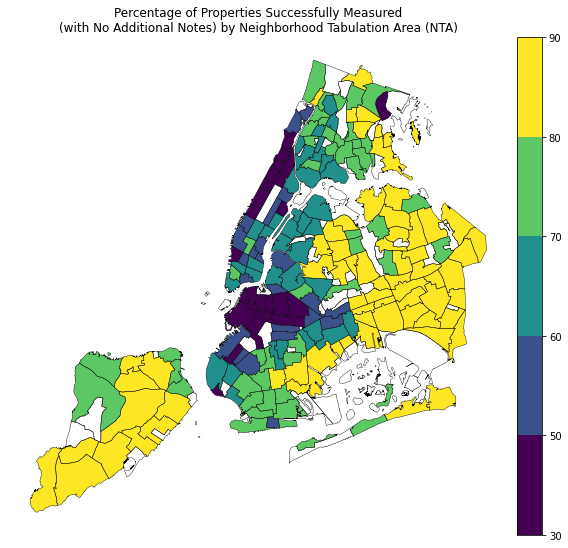

In [26]:
fig, ax = plt.subplots(figsize=(8, 8))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cmap = plt.cm.viridis
norm = mpl.colors.BoundaryNorm([30, 50, 60, 70, 80, 90], cmap.N)

(gdf_merged
.loc[~gdf_merged["nta2020"].isin(nta_exclude)]
.plot(
    column='perc_measured',
    legend=True,
    cmap=cmap,
    cax=cax,
    norm=norm,
    ax=ax)
)

gdf.plot(ax=ax, facecolor='None', linewidth=.4)

ax.set_title('Percentage of Properties Successfully Measured\n\
(with No Additional Notes) by Neighborhood Tabulation Area (NTA)', fontsize=12)
ax.axis('off')

plt.tight_layout()
plt.savefig('figures/successfully-measured.png', dpi=250, bbox_inches='tight')

**Figure xx: Percent of properties that were Successfully Measured by Neighborhood Tabulation Area (NTA).**

Caption this for later.